시간당 자전거 대여량을 예측하는 [Bike Sharing Demand](https://www.kaggle.com/c/bike-sharing-demand) 입니다. 워싱턴 D.C 소재의 자전거 대여 스타트업 [Capital Bikeshare](https://www.capitalbikeshare.com/)의 데이터를 활용하여, 특정 시간대에 얼마나 많은 사람들이 자전거를 대여하는지 예측하는 것이 목표입니다.

사람들이 자전거를 대여하는데는 많은 요소가 관여되어 있을 겁니다. 가령 **시간(새벽보다 낮에 많이 빌리겠죠)**, **날씨(비가 오면 자전거를 대여하지 않을 겁니다)**, **근무일(근무 시간에는 자전거를 대여하지 않겠죠)** 등. 이런 모든 요소를 조합하여 워싱턴 D.C의 자전거 교통량을 예측해주세요. 이번 경진대회에서는 기존까지 배웠던 프로그래밍 언어와 인공지능&머신러닝 능력 외에도, 자전거 렌탈 시장에 대한 약간의 전문지식, 그리고 일반인의 기초 상식을 총동원 할 수 있습니다.

In [1]:
# 필요한 패키지를 import 하는 구간
%matplotlib inline
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import make_scorer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

In [2]:
# 화면에 출력하는 데이터 프레임의 최대 row 수를 1000으로 설정합니다.
pd.set_option('display.max_rows', 1000)

# 화면에 출력하는 데이터 프레임의 최대 column 수를 1000으로 설정합니다.
pd.set_option('display.max_columns', 1000)

In [3]:
import matplotlib
from IPython.display import set_matplotlib_formats

# Mac OS를 이용하고 있기 떄문에 AppleGothic을 설정했습니다.
# 윈도우의 경우 다른 폰트를 사용해주셔야 합니다. 나눔폰트가 있는 경우 'NanumGothic' 없는 경우에는 'Malgun Gothic'을 사용해주세요.
matplotlib.rc('font', family='AppleGothic')
# matplotlib.rc('font', family='NanumGothic')

# 별도로, 폰트를 바꿀 경우 마이너스가 표시되지 않는 경우도 있는데 이를 막아주는 코드입니다.
matplotlib.rc('axes', unicode_minus=False)

# retina 옵션을 통해 해상도를 올립니다.
set_matplotlib_formats('retina')

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

### 속성(컬럼) 설명(Column explain)

 * **datetime** - 시간. 연-월-일 시:분:초 로 표현합니다. (가령 2011-01-01 00:00:00은 2011년 1월 1일 0시 0분 0초)
 * **season** - 계절. 봄(1), 여름(2), 가을(3), 겨울(4) 순으로 표현합니다.
 * **holiday** - 공휴일. 1이면 공휴일이며, 0이면 공휴일이 아닙니다.
 * **workingday** - 근무일. 1이면 근무일이며, 0이면 근무일이 아닙니다.
 * **weather** - 날씨. 1 ~ 4 사이의 값을 가지며, 구체적으로는 다음과 같습니다.
   * 1: 아주 깨끗한 날씨입니다. 또는 아주 약간의 구름이 끼어있습니다.
   * 2: 약간의 안개와 구름이 끼어있는 날씨입니다.
   * 3: 약간의 눈, 비가 오거나 천둥이 칩니다.
   * 4: 아주 많은 비가 오거나 우박이 내립니다.
 * **temp** - 온도. 섭씨(Celsius)로 적혀있습니다.
 * **atemp** - 체감 온도. 마찬가지로 섭씨(Celsius)로 적혀있습니다.
 * **humidity** - 습도.
 * **windspeed** - 풍속.
 * **casual** - 비회원(non-registered)의 자전거 대여량.
 * **registered** - 회원(registered)의 자전거 대여량.
 * **count** - 총 자전거 대여랑. 비회원(casual) + 회원(registered)과 동일합니다.

### 데이터 셋 로드(Load Dataset)

In [4]:
# 데이터 셋을 로드하는 커널입니다
# 각각 data 폴더 내에 있는 train.csv, test.csv파일을 불러옵니다
# parse_dates : datetime 컬럼을 실제 날짜 처럼 연산하게 parsing 처리합니다
train = pd.read_csv("data/train.csv", parse_dates=["datetime"])
test = pd.read_csv("data/test.csv", parse_dates=["datetime"])

# 불러온 train데이터를 확인합니다.
print(train.shape)
train.head()

(10886, 12)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [5]:
# 불러온 test 데이터를 확인합니다.
print(test.shape)
test.head()

(6493, 9)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


### 데이터 전처리(Data Preprocessing)

In [6]:
# train 데이터 전처리
# 먼저 datetime 데이터 처리 : 연, 월, 일, 시간, 분, 초 등으로 처리
train['datetime-year'] = train['datetime'].dt.year
train['datetime-month'] = train['datetime'].dt.month
train['datetime-day'] = train['datetime'].dt.day
train['datetime-hour'] = train['datetime'].dt.hour
train['datetime-minute'] = train['datetime'].dt.minute
train['datetime-second'] = train['datetime'].dt.second

print(train.shape)
train[["datetime-year", "datetime-month", "datetime-day", "datetime-hour", "datetime-minute",
       "datetime-second"]].head()

(10886, 18)


,datetime-year,datetime-month,datetime-day,datetime-hour,datetime-minute,datetime-second
0,2011,1,1,0,0,0
1,2011,1,1,1,0,0
2,2011,1,1,2,0,0
3,2011,1,1,3,0,0
4,2011,1,1,4,0,0


In [7]:
# test 데이터 전처리
# train과 동일하게 진행합니다.
test['datetime-year'] = test['datetime'].dt.year
test['datetime-month'] = test['datetime'].dt.month
test['datetime-day'] = test['datetime'].dt.day
test['datetime-hour'] = test['datetime'].dt.hour
test['datetime-minute'] = test['datetime'].dt.minute
test['datetime-second'] = test['datetime'].dt.second

print(test.shape)
test[["datetime-year", "datetime-month", "datetime-day", "datetime-hour", "datetime-minute",
       "datetime-second"]].head()

(6493, 15)


,datetime-year,datetime-month,datetime-day,datetime-hour,datetime-minute,datetime-second
0,2011,1,20,0,0,0
1,2011,1,20,1,0,0
2,2011,1,20,2,0,0
3,2011,1,20,3,0,0
4,2011,1,20,4,0,0


In [8]:
# 요일의 정보를 추가합니다.
# train, test 모두 다 컬럼을 추가합니다.
train["datetime-dayofweek"] = train["datetime"].dt.dayofweek
test["datetime-dayofweek"] = test["datetime"].dt.dayofweek

print(train.shape)
train.head()

print(test.shape)
test.head()

(10886, 19)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,datetime-year,datetime-month,datetime-day,datetime-hour,datetime-minute,datetime-second,datetime-dayofweek
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0,0,0,5
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1,0,0,5
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2,0,0,5
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,1,1,3,0,0,5
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,1,1,4,0,0,5


(6493, 16)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,datetime-year,datetime-month,datetime-day,datetime-hour,datetime-minute,datetime-second,datetime-dayofweek
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027,2011,1,20,0,0,0,3
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000,2011,1,20,1,0,0,3
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000,2011,1,20,2,0,0,3
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014,2011,1,20,3,0,0,3
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014,2011,1,20,4,0,0,3


In [9]:
# dayofweek가 정수값으로 나타내어져 있어 실제 데이터분석에 다소 불편한 감이 있습니다
# 따라서 사람이 알아보기 쉬운 Mon, Tue, ... , Sun 값으로 바꾸는 과정입니다.
# train 데이터
train.loc[train["datetime-dayofweek"] == 0, "datetime-dayofweek(hum)"] = "Monday"
train.loc[train["datetime-dayofweek"] == 1, "datetime-dayofweek(hum)"] = "Tuesday"
train.loc[train["datetime-dayofweek"] == 2, "datetime-dayofweek(hum)"] = "Wednesday"
train.loc[train["datetime-dayofweek"] == 3, "datetime-dayofweek(hum)"] = "Thursday"
train.loc[train["datetime-dayofweek"] == 4, "datetime-dayofweek(hum)"] = "Friday"
train.loc[train["datetime-dayofweek"] == 5, "datetime-dayofweek(hum)"] = "Saturday"
train.loc[train["datetime-dayofweek"] == 6, "datetime-dayofweek(hum)"] = "Sunday"

print(train.shape)
train[["datetime-year", "datetime-month", "datetime-day", "datetime-dayofweek(hum)",
       "datetime-hour", "datetime-minute", "datetime-second"]].head()

(10886, 20)


,datetime-year,datetime-month,datetime-day,datetime-dayofweek(hum),datetime-hour,datetime-minute,datetime-second
0,2011,1,1,Saturday,0,0,0
1,2011,1,1,Saturday,1,0,0
2,2011,1,1,Saturday,2,0,0
3,2011,1,1,Saturday,3,0,0
4,2011,1,1,Saturday,4,0,0


In [10]:
# test 데이터
test.loc[train["datetime-dayofweek"] == 0, "datetime-dayofweek(hum)"] = "Monday"
test.loc[train["datetime-dayofweek"] == 1, "datetime-dayofweek(hum)"] = "Tuesday"
test.loc[train["datetime-dayofweek"] == 2, "datetime-dayofweek(hum)"] = "Wednesday"
test.loc[train["datetime-dayofweek"] == 3, "datetime-dayofweek(hum)"] = "Thursday"
test.loc[train["datetime-dayofweek"] == 4, "datetime-dayofweek(hum)"] = "Friday"
test.loc[train["datetime-dayofweek"] == 5, "datetime-dayofweek(hum)"] = "Saturday"
test.loc[train["datetime-dayofweek"] == 6, "datetime-dayofweek(hum)"] = "Sunday"

print(test.shape)
test[["datetime-year", "datetime-month", "datetime-day", "datetime-dayofweek(hum)",
       "datetime-hour", "datetime-minute", "datetime-second"]].head()

(6493, 17)


,datetime-year,datetime-month,datetime-day,datetime-dayofweek(hum),datetime-hour,datetime-minute,datetime-second
0,2011,1,20,Saturday,0,0,0
1,2011,1,20,Saturday,1,0,0
2,2011,1,20,Saturday,2,0,0
3,2011,1,20,Saturday,3,0,0
4,2011,1,20,Saturday,4,0,0


#### One-Hot-Encoding

머신러닝 알고리즘을 돌릴 때 수치 데이터의 합에 의한 잘못된 학습을 방지하고자 **One-Hot-Encoding**이 필요한 컬럼 값에 대해 전처리를 진행합니다.

In [11]:
# One-Hot-Encoding을 진행할 컬럼 값  : season, weather, datetime-dayofweek(수치값)
# train데이터에 대한 One-Hot-Encoding
# train : season
train["season_1"] = train["season"] == 1
train["season_2"] = train["season"] == 2
train["season_3"] = train["season"] == 3
train["season_4"] = train["season"] == 4

# train : weather
train["weather_1"] = train["weather"] == 1
train["weather_2"] = train["weather"] == 2
train["weather_3"] = train["weather"] == 3
train["weather_4"] = train["weather"] == 4

# train : datetime-dayofweek
train["dayofweek_0"] = train["datetime-dayofweek"] == 0
train["dayofweek_1"] = train["datetime-dayofweek"] == 1
train["dayofweek_2"] = train["datetime-dayofweek"] == 2
train["dayofweek_3"] = train["datetime-dayofweek"] == 3
train["dayofweek_4"] = train["datetime-dayofweek"] == 4
train["dayofweek_5"] = train["datetime-dayofweek"] == 5
train["dayofweek_6"] = train["datetime-dayofweek"] == 6

print(train.shape)
train.loc[:300]

(10886, 35)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,datetime-year,datetime-month,datetime-day,datetime-hour,datetime-minute,datetime-second,datetime-dayofweek,datetime-dayofweek(hum),season_1,season_2,season_3,season_4,weather_1,weather_2,weather_3,weather_4,dayofweek_0,dayofweek_1,dayofweek_2,dayofweek_3,dayofweek_4,dayofweek_5,dayofweek_6
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3,13,16,2011,1,1,0,0,0,5,Saturday,True,False,False,False,True,False,False,False,False,False,False,False,False,True,False
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8,32,40,2011,1,1,1,0,0,5,Saturday,True,False,False,False,True,False,False,False,False,False,False,False,False,True,False
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5,27,32,2011,1,1,2,0,0,5,Saturday,True,False,False,False,True,False,False,False,False,False,False,False,False,True,False
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3,10,13,2011,1,1,3,0,0,5,Saturday,True,False,False,False,True,False,False,False,False,False,False,False,False,True,False
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0,1,1,2011,1,1,4,0,0,5,Saturday,True,False,False,False,True,False,False,False,False,False,False,False,False,True,False
5,2011-01-01 05:00:00,1,0,0,2,9.84,12.880,75,6.0032,0,1,1,2011,1,1,5,0,0,5,Saturday,True,False,False,False,False,True,False,False,False,False,False,False,False,True,False
6,2011-01-01 06:00:00,1,0,0,1,9.02,13.635,80,0.0000,2,0,2,2011,1,1,6,0,0,5,Saturday,True,False,False,False,True,False,False,False,False,False,False,False,False,True,False
7,2011-01-01 07:00:00,1,0,0,1,8.20,12.880,86,0.0000,1,2,3,2011,1,1,7,0,0,5,Saturday,True,False,False,False,True,False,False,False,False,False,False,False,False,True,False
8,2011-01-01 08:00:00,1,0,0,1,9.84,14.395,75,0.0000,1,7,8,2011,1,1,8,0,0,5,Saturday,True,False,False,False,True,False,False,False,False,False,False,False,False,True,False
9,2011-01-01 09:00:00,1,0,0,1,13.12,17.425,76,0.0000,8,6,14,2011,1,1,9,0,0,5,Saturday,True,False,False,False,True,False,False,False,False,False,False,False,False,True,False


In [12]:
# One-Hot-Encoding을 진행할 컬럼 값  : season, weather, datetime-dayofweek(수치값)
# test데이터에 대한 One-Hot-Encoding
# test : season
test["season_1"] = train["season"] == 1
test["season_2"] = test["season"] == 2
test["season_3"] = test["season"] == 3
test["season_4"] = test["season"] == 4

# test : weather
test["weather_1"] = test["weather"] == 1
test["weather_2"] = test["weather"] == 2
test["weather_3"] = test["weather"] == 3
test["weather_4"] = test["weather"] == 4

# test : datetime-dayofweek
test["dayofweek_0"] = test["datetime-dayofweek"] == 0
test["dayofweek_1"] = test["datetime-dayofweek"] == 1
test["dayofweek_2"] = test["datetime-dayofweek"] == 2
test["dayofweek_3"] = test["datetime-dayofweek"] == 3
test["dayofweek_4"] = test["datetime-dayofweek"] == 4
test["dayofweek_5"] = test["datetime-dayofweek"] == 5
test["dayofweek_6"] = test["datetime-dayofweek"] == 6

print(test.shape)
test.loc[:300]

(6493, 32)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,datetime-year,datetime-month,datetime-day,datetime-hour,datetime-minute,datetime-second,datetime-dayofweek,datetime-dayofweek(hum),season_1,season_2,season_3,season_4,weather_1,weather_2,weather_3,weather_4,dayofweek_0,dayofweek_1,dayofweek_2,dayofweek_3,dayofweek_4,dayofweek_5,dayofweek_6
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027,2011,1,20,0,0,0,3,Saturday,True,False,False,False,True,False,False,False,False,False,False,True,False,False,False
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000,2011,1,20,1,0,0,3,Saturday,True,False,False,False,True,False,False,False,False,False,False,True,False,False,False
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000,2011,1,20,2,0,0,3,Saturday,True,False,False,False,True,False,False,False,False,False,False,True,False,False,False
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014,2011,1,20,3,0,0,3,Saturday,True,False,False,False,True,False,False,False,False,False,False,True,False,False,False
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014,2011,1,20,4,0,0,3,Saturday,True,False,False,False,True,False,False,False,False,False,False,True,False,False,False
5,2011-01-20 05:00:00,1,0,1,1,9.84,11.365,60,15.0013,2011,1,20,5,0,0,3,Saturday,True,False,False,False,True,False,False,False,False,False,False,True,False,False,False
6,2011-01-20 06:00:00,1,0,1,1,9.02,10.605,60,15.0013,2011,1,20,6,0,0,3,Saturday,True,False,False,False,True,False,False,False,False,False,False,True,False,False,False
7,2011-01-20 07:00:00,1,0,1,1,9.02,10.605,55,15.0013,2011,1,20,7,0,0,3,Saturday,True,False,False,False,True,False,False,False,False,False,False,True,False,False,False
8,2011-01-20 08:00:00,1,0,1,1,9.02,10.605,55,19.0012,2011,1,20,8,0,0,3,Saturday,True,False,False,False,True,False,False,False,False,False,False,True,False,False,False
9,2011-01-20 09:00:00,1,0,1,2,9.84,11.365,52,15.0013,2011,1,20,9,0,0,3,Saturday,True,False,False,False,False,True,False,False,False,False,False,True,False,False,False


In [13]:
train.tail()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,datetime-year,datetime-month,datetime-day,datetime-hour,datetime-minute,datetime-second,datetime-dayofweek,datetime-dayofweek(hum),season_1,season_2,season_3,season_4,weather_1,weather_2,weather_3,weather_4,dayofweek_0,dayofweek_1,dayofweek_2,dayofweek_3,dayofweek_4,dayofweek_5,dayofweek_6
10881,2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.0027,7,329,336,2012,12,19,19,0,0,2,Wednesday,False,False,False,True,True,False,False,False,False,False,True,False,False,False,False
10882,2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.0013,10,231,241,2012,12,19,20,0,0,2,Wednesday,False,False,False,True,True,False,False,False,False,False,True,False,False,False,False
10883,2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.0013,4,164,168,2012,12,19,21,0,0,2,Wednesday,False,False,False,True,True,False,False,False,False,False,True,False,False,False,False
10884,2012-12-19 22:00:00,4,0,1,1,13.94,17.425,61,6.0032,12,117,129,2012,12,19,22,0,0,2,Wednesday,False,False,False,True,True,False,False,False,False,False,True,False,False,False,False
10885,2012-12-19 23:00:00,4,0,1,1,13.12,16.665,66,8.9981,4,84,88,2012,12,19,23,0,0,2,Wednesday,False,False,False,True,True,False,False,False,False,False,True,False,False,False,False


In [14]:
test.tail()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,datetime-year,datetime-month,datetime-day,datetime-hour,datetime-minute,datetime-second,datetime-dayofweek,datetime-dayofweek(hum),season_1,season_2,season_3,season_4,weather_1,weather_2,weather_3,weather_4,dayofweek_0,dayofweek_1,dayofweek_2,dayofweek_3,dayofweek_4,dayofweek_5,dayofweek_6
6488,2012-12-31 19:00:00,1,0,1,2,10.66,12.880,60,11.0014,2012,12,31,19,0,0,0,Wednesday,True,False,False,False,False,True,False,False,True,False,False,False,False,False,False
6489,2012-12-31 20:00:00,1,0,1,2,10.66,12.880,60,11.0014,2012,12,31,20,0,0,0,Wednesday,True,False,False,False,False,True,False,False,True,False,False,False,False,False,False
6490,2012-12-31 21:00:00,1,0,1,1,10.66,12.880,60,11.0014,2012,12,31,21,0,0,0,Wednesday,True,False,False,False,True,False,False,False,True,False,False,False,False,False,False
6491,2012-12-31 22:00:00,1,0,1,1,10.66,13.635,56,8.9981,2012,12,31,22,0,0,0,Wednesday,True,False,False,False,True,False,False,False,True,False,False,False,False,False,False
6492,2012-12-31 23:00:00,1,0,1,1,10.66,13.635,65,8.9981,2012,12,31,23,0,0,0,Wednesday,True,False,False,False,True,False,False,False,True,False,False,False,False,False,False


### 탐험적 데이터 분석(EDA)

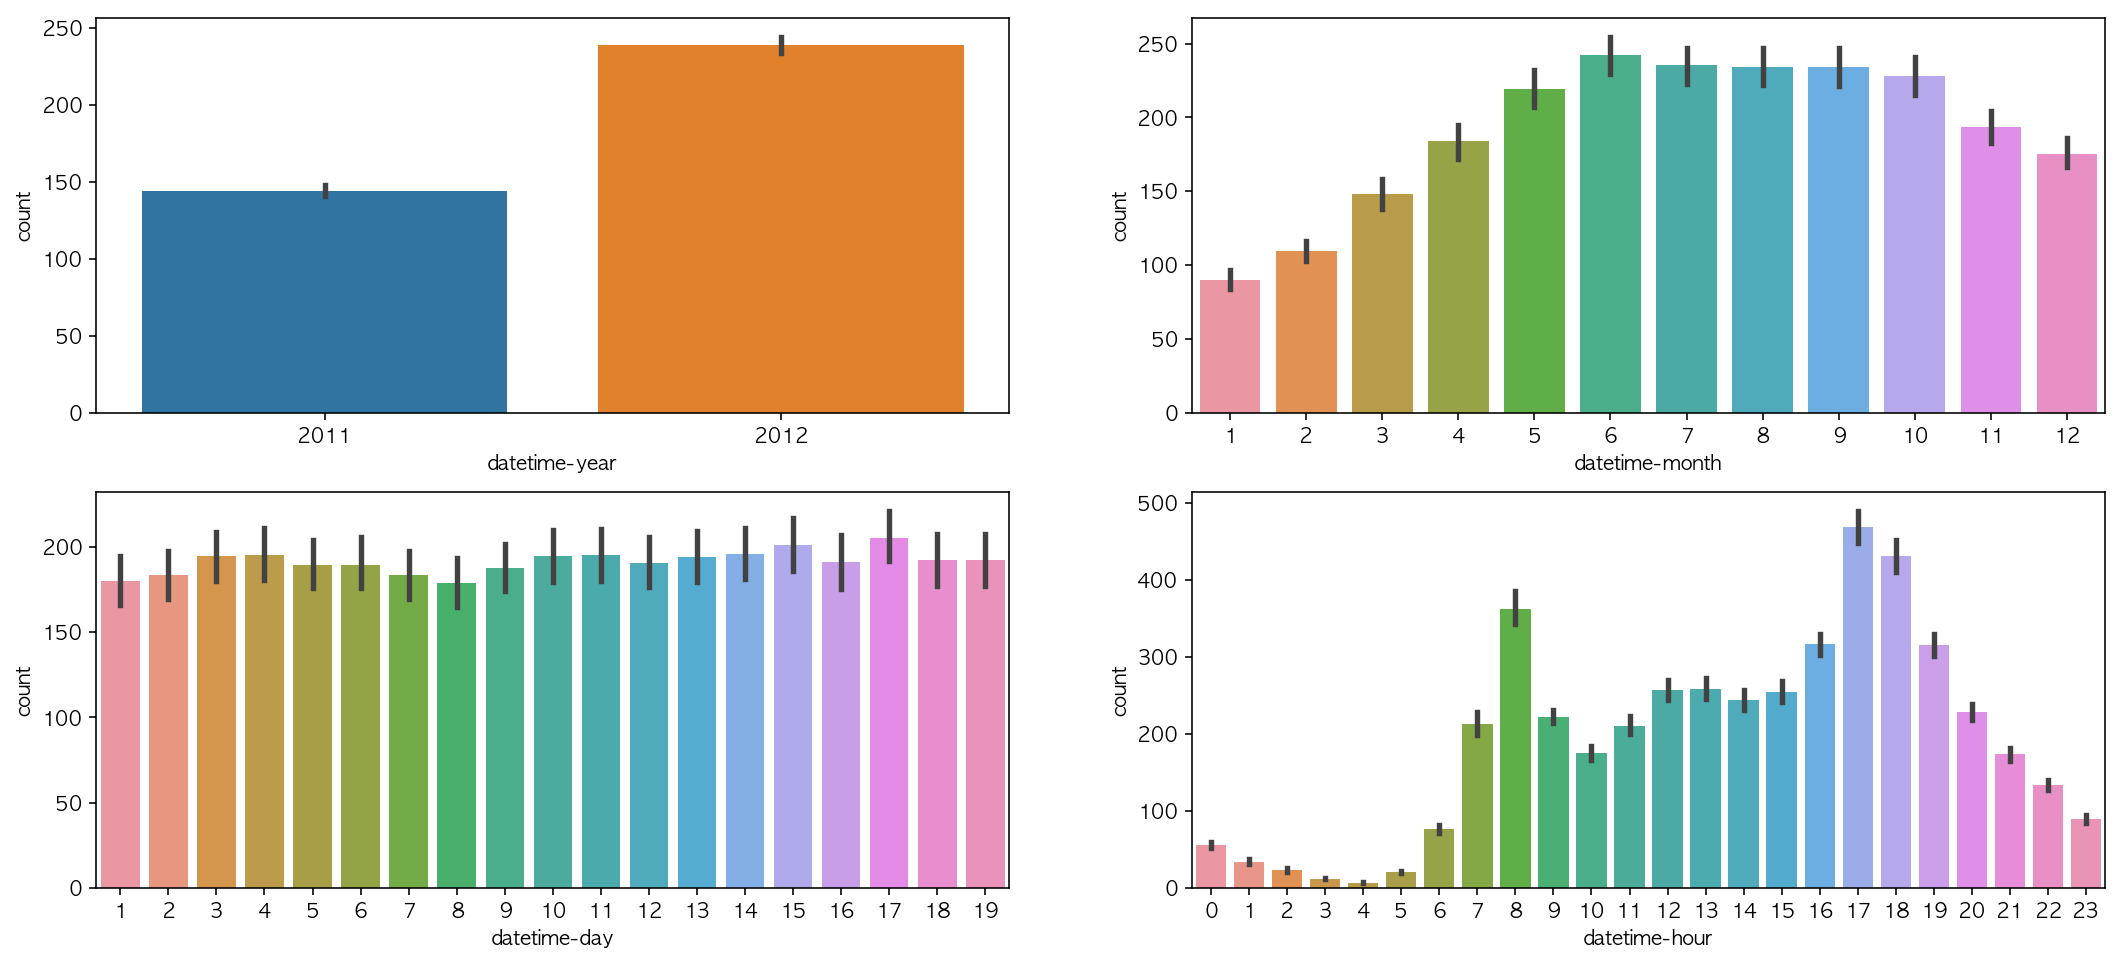

In [15]:
# 시간에 따른 count 값 시각화 분석
# subplot 설정과 set_size_inches설정
figure, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2)
figure.set_size_inches(18, 8)

# seaborn의 barplot을 이용해 시간대 별로 count데이터를 시각화 해 봅니다
sns.barplot(data=train, x="datetime-year", y="count", ax=ax1)
sns.barplot(data=train, x="datetime-month", y="count", ax=ax2)
sns.barplot(data=train, x="datetime-day", y="count", ax=ax3)
sns.barplot(data=train, x="datetime-hour", y="count", ax=ax4)

### 머신러닝 파트(Machine Learning Part)